<a href="https://colab.research.google.com/github/EliaFeltrin/KIND_project/blob/main/NLP_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Name Entity Recognition

In [ ]:
def get_string_from_df(dataframe, puntuaction):
  '''
  Transforms the tokenized dataset into a single string.
  
  Parameters
  ----------
  dataframe: DataFrame
    structure containing the tokenized dataset

  Returns
  -------
  text: str
    string concatenating all the tokens of the dataset
  '''
  text_df = dataframe.loc[:,'Token']
  text = ''
  for token in text_df:
    token += ' '
    text += token
  return text

## Introduction

In [4]:
# Cloning the github repository
! git clone https://github.com/EliaFeltrin/KIND_project.git

Cloning into 'KIND_project'...


In [5]:
# Installing the library needed in the following part of the project

# Sequence labeling library, used for POS tagging and NER
!spacy download it_core_news_sm

     ---------------------------------------- 13.0/13.0 MB 3.7 MB/s eta 0:00:00
  Using cached pydantic-1.8.2-py3-none-any.whl (126 kB)
  Attempting uninstall: pydantic
    Found existing installation: pydantic 1.10.2
    Uninstalling pydantic-1.10.2:
      Successfully uninstalled pydantic-1.10.2
✔ Download and installation successful
You can now load the package via spacy.load('it_core_news_sm')


DEPRECATION: https://github.com/explosion/spacy-models/releases/download/it_core_news_sm-3.3.0/it_core_news_sm-3.3.0-py3-none-any.whl#egg=it_core_news_sm==3.3.0 contains an egg fragment with a non-PEP 508 name pip 25.0 will enforce this behaviour change. A possible replacement is to use the req @ url syntax, and remove the egg fragment. Discussion can be found at https://github.com/pypa/pip/issues/11617


In [8]:
# Importing the main libraries
import pandas as pd
import numpy as np
import spacy as spc
import it_core_news_sm
from collections import Counter
import matplotlib.pyplot as plt
from wordcloud import WordCloud

In [ ]:
dataset_degasperi = pd.read_csv('./KIND_project/dataset/KIND-main/dataset/degasperi_train.tsv', sep='\t', header=None)
dataset_degasperi = dataset_degasperi.rename(columns={0: 'Token', 1: 'Entity'})

dataset_moro = pd.read_csv('./KIND_project/dataset/KIND-main/dataset/moro_train.tsv', sep='\t', header=None)
dataset_moro = dataset_moro.rename(columns={0: 'Token', 1: 'Entity'})

dataset_fiction = pd.read_csv('./KIND_project/dataset/KIND-main/dataset/fiction_train.tsv', sep='\t', header=None)
dataset_fiction = dataset_fiction.rename(columns={0: 'Token', 1: 'Entity'})

dataset_wikinews = pd.read_csv('./KIND_project/dataset/KIND-main/dataset/wikinews_train.tsv', sep='\t', header=None)
dataset_wikinews = dataset_wikinews.rename(columns={0: 'Token', 1: 'Entity'})

## Embedding computation

In [ ]:
# Elia valuta se può essere utile, altrimenti eliminiamo
def compute_statistics(dataset_name, dataset, statistics_df):
  '''
  Computes the statistics of the dataset and adds it into an aggregated structure

  Parameters
  ----------
  dataset_name: str
  dataset: DataFrame
  statistics_df: DataFrame

  Returns
  -------
  statistics_df: DataFrame
  '''
  if statistics_df is None:
    columns = ['Dataset', 'Number of tokens', 'Number of unique tokens', 'Entity tag types']
    statistics_df = pd.DataFrame([[dataset_name, len(dataset), len(dataset['Token'].unique()), sorted(dataset['Tag'].unique())]], columns=columns)
  else:
    columns = ['Dataset', 'Number of tokens', 'Number of unique tokens', 'Entity tag types']
    statistics_df = pd.concat([statistics_df, pd.DataFrame([[dataset_name, len(dataset), len(dataset['Token'].unique()), sorted(dataset['Tag'].unique())]], columns=columns)])
  return statistics_df



  # Rimuovi l'hardcoding dei nomi delle colonne

In [ ]:
datasets_df = []
dataset_stats_df = None

for dataset_name in dataset_names:
  dataset_df = pd.read_csv(dataset_name, sep='\t', names=['Token', 'Tag'])
  datasets_df.append(dataset_df)
  dataset_stats_df = compute_statistics(dataset_name, dataset_df, dataset_stats_df)

dataset_stats_df.style.hide(axis='index')

## POS tagging

In [ ]:
# Loading the italian model
nlp_model = it_core_news_sm.load()

text_degasperi = ' '.join(dataset_degasperi.iloc[:, 0].tolist())
parsed_text_degasperi = nlp_model(text_degasperi)

text_fiction = ' '.join(dataset_fiction.iloc[:, 0].tolist())
parsed_text_fiction = nlp_model(text_fiction)

text_wikinews = ' '.join(dataset_wikinews.iloc[:, 0].tolist())
parsed_text_wiki = nlp_model(text_wikinews[:1000000])

text_moro = ' '.join(dataset_moro.iloc[:, 0].tolist())
parsed_text_moro = nlp_model(text_moro[:1000000])

In [ ]:
def merge_counters(counter1, counter2):

  '''
  Takes 2 counters with different shapes and in the smallest one ad also the key that are currently inside with a value of 0

  Parameters
  ----------
  counter1: Counter
    Counter with smallest shape that has to be incremented
  counter2: Counter
    Counter with the larger shape

  Returns
  -------
  new_counter: Counter
    Counter containing all the tuple of the smallest one and the tuples (key, 0) of the larger one that were no present in the small one
  '''
  new_counter = counter1    

  for key, value in counter2.items():
    if key not in new_counter.keys():
      new_counter[key] = 0 

  return new_counter

In [ ]:
def plot_wordCloud_counters(counters):

  '''
  Takes as input a list of counters and it plots the wordCloud

  Parameters
  ----------
  cunters: list(Counter)
    List of counters that has to be plotted. It does not require that all the counters has the same shape

  '''

  word_cloud_counter = Counter()
  for counter in list_counters:
    word_cloud_counter.update(counter)
  # Generate a word cloud from the POS counts
  wordcloud = WordCloud(background_color='white').generate_from_frequencies(word_cloud_counter)

  # Plot the word cloud
  plt.imshow(wordcloud, interpolation='bilinear')
  plt.axis("off")
  plt.show()

In [ ]:
def plot_groupedBar_counters(counters):

  '''
  Takes as input a list of counters and it plots in the same bar chart the counts

  Parameters
  ----------
  cunters: list(Counter)
    List of counters that has to be plotted. It does not require that all the counters has the same shape

  '''
  
  max_length = max(map(len, list_counters))                         # max length of the counters
  max_position = list(map(len, list_counters)).index(max_length)    # position in the list of the counter with max length

  # For each counter that is not the one of maximum dimension I merge it with all the other ones. The result is a list with counters having all the same keys
  for i in range(len(list_counters)):
    if i != max_position:
      list_counters[i] = merge_counters(list_counters[i], list_counters[max_position])

  # We plot each counter inside the bar chart
  x = np.arange(max_length)
  width=0.2
  multiplier = 0
  for counter in list_counters:
    offset = width * multiplier
    labels, values = zip(*sorted(counter.items()))
    plt.bar(x + offset, values, width=width)
    multiplier += 1

  plt.title("POS Tag Frequency Distribution Degasperi")
  plt.xlabel("POS Tag")
  plt.ylabel("Frequency")
  plt.xticks(x + width, sorted(list_counters[max_position]), rotation='vertical')
  plt.show()

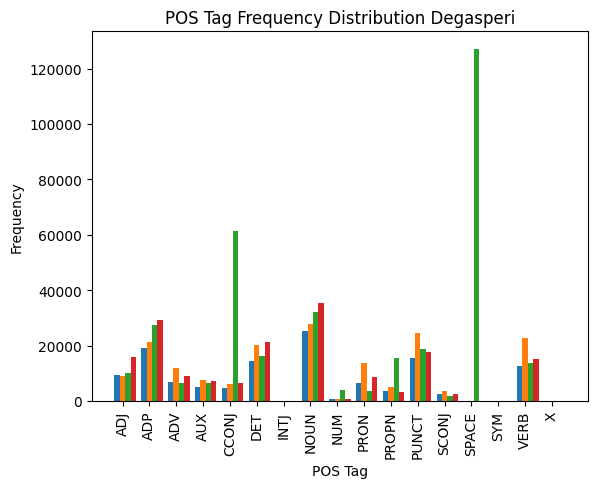

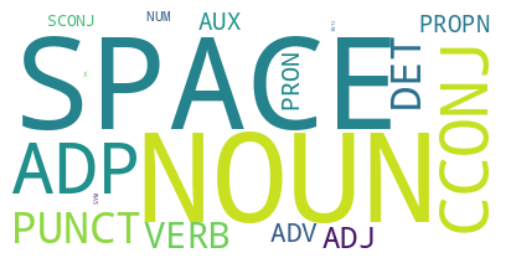

In [ ]:
# Get the frequency distribution of POS tags
pos_freq_degasperi = Counter([token.pos_ for token in parsed_text_degasperi])
pos_freq_fiction = Counter([token.pos_ for token in parsed_text_fiction])
pos_freq_wiki = Counter([token.pos_ for token in parsed_text_wiki])
pos_freq_moro = Counter([token.pos_ for token in parsed_text_moro])

list_counters = [pos_freq_degasperi, pos_freq_fiction, pos_freq_wiki, pos_freq_moro]
plot_groupedBar_counters(list_counters)
plot_wordCloud_counters(list_counters)

# CODICE ELIA

# KIND DATASET

## Brief Description
KIND (Kessler Italian Named-entities Dataset) is a dataset released in 2022 by researchers from Fondazione Bruno Kessler and the University of Trento. It contains 1 million tokens, of which 600K name-entities are manually annotated. The entities belong to 3 classes (people, location, organization). The texts come from various sources of the Italian language, such as news articles, literature, and political speeches, making it a multi-domain dataset. 
The following table shows the dataset composition:

<table>
  <thead>
    <tr>
      <th rowspan="2">Dataset</th>
      <th rowspan="2">Documents</th>
      <th rowspan="2">Tokens</th>
      <th colspan="4">Train</th>
      <th colspan="4">Test</th>
    </tr>
    <tr>
      <th>Total</th>
      <th>PER</th>
      <th>ORG</th>
      <th>LOC</th>
      <th>Total</th>
      <th>PER</th>
      <th>ORG</th>
      <th>LOC</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>Wikinews</td>
      <td>1,000</td>
      <td>308,622</td>
      <td>247,528</td>
      <td>8,928</td>
      <td>7,593</td>
      <td>6,862</td>
      <td>61,094</td>
      <td>1,802</td>
      <td>1,823</td>
      <td>1,711</td>
    </tr>
    <tr>
      <td>Fiction</td>
      <td>86</td>
      <td>192,448</td>
      <td>170,942</td>
      <td>3,439</td>
      <td>182</td>
      <td>733</td>
      <td>21,506</td>
      <td>636</td>
      <td>284</td>
      <td>463</td>
    </tr>
    <tr>
      <td>Aldo Moro</td>
      <td>250</td>
      <td>392,604</td>
      <td>309,798</td>
      <td>1,459</td>
      <td>4,842</td>
      <td>2,024</td>
      <td>82,806</td>
      <td>282</td>
      <td>934</td>
      <td>807</td>
    </tr>
    <tr>
      <td>Alcide De Gasperi</td>
      <td>158</td>
      <td>150,632</td>
      <td>117,997</td>
      <td>1,129</td>
      <td>2,396</td>
      <td>1,046</td>
      <td>32,635</td>
      <td>253</td>
      <td>533</td>
      <td>274</td>
    </tr>
    <tr>
      <td><strong>Total</strong></td>
      <td><strong>1494</strong></td>
      <td><strong>1,044,306</strong></td>
      <td><strong>846,265</strong></td>
      <td><strong>14,955</strong></td>
      <td><strong>15,013</strong></td>
      <td><strong>10,665</strong></td>
      <td><strong>198,041</strong></td>
      <td><strong>2,973</strong></td>
      <td><strong>3,574</strong></td>
      <td><strong>3,255</strong></td>
    </tr>
  </tbody>
</table>


##Annotation Tagging scheme
The tokens of all datasets, except for Aldo Moro, have been manually labeled using the IOB (Inside-Outside-Beginning) convention: each entity is labeled as begin-of-entity (B-[ent]) or continuation-of-entity (I-[ent]). The annotations of the Aldo Moro dataset, instead, were carried out with a mixed process that used both manual and automatic annotations (subsequently checked by hand); due to some differences in the convention for annotation, this dataset does not contain information for composite entities (beginning, continuation). For more details, please refer to the paper related with the dataset release: https://arxiv.org/abs/2112.15099

An example of the annotations is reported here: 


In [ ]:
# IOB annotation (from ADG_dev.tsv)
Nel	O
nostro	O
Trentino	B-LOC
attraversiamo	O
un	O
momento	O
storico	O
importante	O
.	O

# non-IOB annotation (from moro_test.tsv)
Dal	O
Consiglio	ORG
nazionale	ORG
del	O
‘	O
75	O
la	O
grande	O
stampa	O
parla	O
di	O
due	O
anime	O
contrapposte	O
del	O
partito	O
.	O

In [ ]:
def to_lowerCase(df):
    return pd.DataFrame({'Token': df['Token'].str.lower(), 'Entity': df['Entity']})

def add_column_names(df):
    return  df.rename(columns={0: 'Token', 1: 'Entity'})


ds = {'ds_dg' : pd.read_csv('./KIND_project/dataset/KIND-main/dataset/degasperi_train.tsv', sep='\t', header=None),
      'ds_mr' : pd.read_csv('./KIND_project/dataset/KIND-main/dataset/moro_train.tsv', sep='\t', header=None),
      'ds_fc' : pd.read_csv('./KIND_project/dataset/KIND-main/dataset/fiction_train.tsv', sep='\t', header=None),
      'ds_wn' : pd.read_csv('./KIND_project/dataset/KIND-main/dataset/wikinews_train.tsv', sep='\t', header=None),
      
      'ds_dg_test' : pd.read_csv('./KIND_project/dataset/KIND-main/dataset/degasperi_test.tsv', sep='\t', header=None),
      'ds_mr_test' : pd.read_csv('./KIND_project/dataset/KIND-main/dataset/moro_test.tsv', sep='\t', header=None),
      'ds_fc_test' : pd.read_csv('./KIND_project/dataset/KIND-main/dataset/fiction_test.tsv', sep='\t', header=None),
      'ds_wn_test' : pd.read_csv('./KIND_project/dataset/KIND-main/dataset/wikinews_test.tsv', sep='\t', header=None),
      
      'ds_dg_IOB' : pd.read_csv('./KIND_project/dataset/KIND-main/evalita-2023/ADG_train.tsv', sep='\t', header=None),
      'ds_fc_IOB' : pd.read_csv('./KIND_project/dataset/KIND-main/evalita-2023/FIC_train.tsv', sep='\t', header=None),
      'ds_wn_IOB' : pd.read_csv('./KIND_project/dataset/KIND-main/evalita-2023/WN_train.tsv', sep='\t', header=None),
      
      'ds_dg_IOB_test' : pd.read_csv('./KIND_project/dataset/KIND-main/evalita-2023/ADG_dev.tsv', sep='\t', header=None),
      'ds_fc_IOB_test' : pd.read_csv('./KIND_project/dataset/KIND-main/evalita-2023/FIC_dev.tsv', sep='\t', header=None),
      'ds_wn_IOB_test' : pd.read_csv('./KIND_project/dataset/KIND-main/evalita-2023/WN_dev.tsv', sep='\t', header=None),
}

# lowercasing tokens, adding column names, compute some stats
avg_doc_len = 0
avg_voc_size = 0

stats = {}

for i in ds.keys():     

    stats[i] = {
        'doc_len' : ds[i]['Token'].count(),
        'voc_size' : ds[i]['Token'].nunique(),

        'n_O' : sum(1 for k in ds[i]['Entity'] if k == 'O'),
        'n_PER' : sum(1 for k in ds[i]['Entity'] if k == 'PER'), 
        'n_ORG' : sum(1 for k in ds[i]['Entity'] if k == 'ORG'),
        'n_LOC' : sum(1 for k in ds[i]['Entity'] if k == 'LOC'),

        'n_I-PER' : sum(1 for k in ds[i]['Entity'] if k == 'I-PER'), 
        'n_I-ORG' : sum(1 for k in ds[i]['Entity'] if k == 'I-ORG'),
        'n_I-LOC' : sum(1 for k in ds[i]['Entity'] if k == 'I-LOC'),

        'n_B-PER' : sum(1 for k in ds[i]['Entity'] if k == 'B-PER'), 
        'n_B-ORG' : sum(1 for k in ds[i]['Entity'] if k == 'B-ORG'),
        'n_B-LOC' : sum(1 for k in ds[i]['Entity'] if k == 'B-LOC'),

        'n_punct': sum(1 for k in ds[i]['Token'] if all(char in string.punctuation for char in k)),
    }
  
avg_doc_len = sum(stats[i]['doc_len'] for i in stats.keys()) / len(stats.keys())
avg_voc_size = sum(stats[i]['voc_size'] for i in stats.keys()) / len(stats.keys())